### Import

#### Local

In [1]:
from pathlib import PosixPath

root = PosixPath('/mnt/projects')

#### Colab

In [2]:
# from google.colab import drive
# from pathlib import PosixPath


# drive.mount('/content/drive')
# root = PosixPath('/content/drive/My Drive/DS/')


In [3]:
import sys

sys.path.append(str(root/'lib'))

In [4]:
from xml.dom import minidom
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.nn.modules.upsampling import Upsample
import cv2
from PIL import Image
from tqdm.autonotebook import tqdm
from ssd import ssd_loss, truth_boxes, total_boxes, iou_table
import matplotlib.pyplot  as plt
from torch.utils.data import Dataset, DataLoader
from os.path import isfile
from joblib import dump, load
from functools import partial
from fastai.train import clip_grad
from torchvision import transforms
from fastai.callbacks import *
from ssd import SSD
from fastai.vision import *
import imagesize

/home/hvlpr/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### VOC read

In [5]:
path = root/'yolo'
voc_path = path/'voc/VOCdevkit/VOC2012/'
images_path = voc_path/'JPEGImages'
anno_path = voc_path/'Annotations'

In [6]:
images_data = {}

In [7]:
# for anno in anno_path.iterdir():
    
#     boxes = []
#     classes = []
#     with minidom.parse(str(anno)) as xmldoc:
#         filename = xmldoc.getElementsByTagName('filename')[0].childNodes[0].data
#         bndboxes = xmldoc.getElementsByTagName('bndbox')
#         names = xmldoc.getElementsByTagName('name')
#         for i in range(len(bndboxes)):
#             bndbox = bndboxes[i]
#             xmin = bndbox.getElementsByTagName('xmin')[0].childNodes[0].data
#             xmax = bndbox.getElementsByTagName('xmax')[0].childNodes[0].data
#             ymin = bndbox.getElementsByTagName('ymin')[0].childNodes[0].data
#             ymax = bndbox.getElementsByTagName('ymax')[0].childNodes[0].data
#             box = [ymin, xmin, ymax, xmax]
#             boxes.append(box)
#             name = names[i].childNodes[0].data
#             classes.append(name)
#         images_data[filename] = [boxes, classes]
    
    

In [8]:
# dict_data = images_data

In [9]:
# classes = list(set([i for x in images_data.values() for i in x[1]]))

In [10]:
# classes_dict = {x: index for index, x in enumerate(classes)}
# classes_dict['background'] = len(classes_dict)

In [11]:
# index_dict = {val: key for key, val in classes_dict.items()}

In [12]:
# index_dict[len(index_dict)] = 'background'

In [13]:
# for key in dict_data:
#     val = dict_data[key]
# #     val[1] = [index_dict.get(x, classes_dict.get(x, index_dict.get(x))) for x in val[1]]
#     val[0] = [[float(v) for v in box] for box in val[0]]

In [14]:
# classes_dict['background'] = len(classes_dict)

In [15]:
# dump(dict_data, voc_path/'data.pkl')

# dump(classes_dict, voc_path/'dict.pkl')

dict_data = load(voc_path/'data.pkl')
classes_dict = load(voc_path/'dict.pkl')


In [16]:
# classes_dict

### Parameters

In [17]:
NBOXES = 3
N_CLASSES = len(classes_dict)
FEATURES = NBOXES*(5 + N_CLASSES)

TX = 0
TY = 1
TW = 2
TH = 3
CONF = 4
bs = 8

IOU_THRES=0.6

IMAGE_GRID = 26
IMAGE_SIZE = 300# 416 ## 
# label = [bouding box, (5), 26, 26]
BOX_SIZDE = IMAGE_SIZE / IMAGE_GRID
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LOSS_REDUCTION = 'sum'

### Data

#### Data

In [18]:
def roundboxes(boxes):
    return [[[b[1], b[0], b[1] + b[3], b[0] + b[2]] for b in boxes], ['face']*len(boxes)]

def emptyboxes():
    return [[[0, 0, 0, 0]], ['background']]

In [19]:
def label_func(x):
    x = PosixPath(x).name
    return dict_data.get(x, emptyboxes())

In [20]:
train_df = pd.DataFrame({'name': list(dict_data.keys())})

In [21]:
data = ObjectItemList.from_df(train_df, path=images_path).split_by_rand_pct()
pad_collate = partial(bb_pad_collate, pad_idx='background')

In [22]:
data = data.label_from_func(label_func)\
.transform(get_transforms(), size=IMAGE_SIZE, tfm_y=True)\
.databunch(bs=bs, val_bs=bs*2, collate_fn=bb_pad_collate)


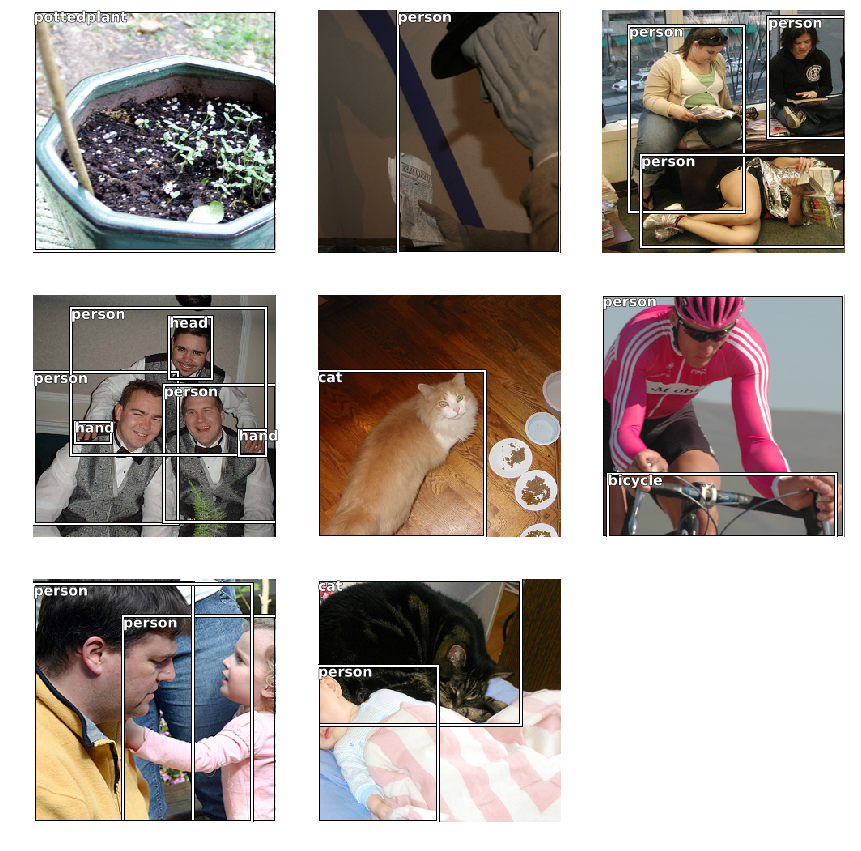

In [23]:
data.show_batch(11)

In [24]:
# data.save(voc_path/'data.bin')

### Test

In [ ]:
batch = next(iter(data.train_dl))

In [ ]:
batch[1][1].shape

In [ ]:
batch_sample = 1
image = batch[0][batch_sample]
boxes = batch[1][0][batch_sample]

In [ ]:
boxes = np.array([[-0.6910, -1.0000,  0.8046,  0.8126], [-0.0524, -0.5271,  0.4435, -0.3555], [-0.7457, -1.0000,  0.3988, -0.3220]])
boxes = (boxes + 1)*(IMAGE_SIZE/2)
boxes = [[x, y, w - x, h - y] for [y, x, h, w] in boxes]

In [ ]:
np_image = image.permute(1, 2, 0).cpu().numpy()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np



# Create a Rectangle patch
for cord in boxes:
    [x, y, w, h] = [int(round(a)) for a in cord]
    print((x,y), (x+w,y+h))
    cv2.rectangle((np_image*255).astype('int32'), (x,y), (x+w,y+h), (0,255,0), 10)

# Display the image
plt.imshow(np_image)



plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np



# Create a Rectangle patch
for cord in boxes:
    [x, y, w, h] = [int(round(a)) for a in cord]
    print((x,y), (x+w,y+h))
    np_image = cv2.rectangle((np_image*255).astype('int32'), (x,y), (x+w,y+h), (0,255,0), 3)

# Display the image
plt.imshow(np_image)



plt.show()

### Feed

In [25]:
from ssd import MobileNetv2SSD, MobileNetSSD

In [26]:
import gc
gc.collect()
torch.cuda.empty_cache()

net = MobileNetSSD(N_CLASSES).to(device)

- Forward to calculate $(g_{c_x}, g_{c_y}, g_w, g_h)$
- Identify corresponding prior $(\hat{c}_x, \hat{c}_y, \hat{w}, \hat{h})$
- Calculate Predicted box 
    - $c_x = g_{c_x}*\hat{w} + \hat{c}_x$
    - $c_y = g_{c_y}*\hat{h} + \hat{c}_y$
    - $w = e^{g_{w}}*\hat{w}$
    - $h = e^{g_{h}}*\hat{h}$
- Calculate IoU
- Match

- Create overlapping table between predicted and ground truth (8732*number of ground truth object)
- Match each priors with greatest overlap
- Categorize as positive and negative match
- Calculate loss

### Loss

In [27]:
from radam import RAdam

In [28]:
eps = 1e-3
ssd_loss = partial(ssd_loss, device=device, im_size=IMAGE_SIZE, eps=eps)

In [29]:
loss = partial(ssd_loss, n_classes=N_CLASSES, smoothl1=nn.SmoothL1Loss(reduction='sum'), cre=nn.CrossEntropyLoss(reduction='sum'), iou_thres=IOU_THRES)

In [30]:
ssd_metric = partial(truth_boxes, im_size=IMAGE_SIZE, thres=IOU_THRES, n_classes=N_CLASSES)

learn = Learner(data, net, loss_func=loss, opt_func=RAdam, metrics=[ssd_metric, total_boxes])
# learn = clip_grad(learn, clip=1)

In [31]:
callbacks = [EarlyStoppingCallback(learn, min_delta=1e-5, patience=3), SaveModelCallback(learn, name='model3')]
learn.callbacks = callbacks

In [32]:
# learn.lr_find()
# learn.recorder.plot()

In [33]:
learn = learn.load('model3')

In [ ]:
learn.fit(100, lr=1e-3, wd=0.0005) # 9500

In [33]:
callbacks = [EarlyStoppingCallback(learn, min_delta=1e-5, patience=10), SaveModelCallback(learn, name='model3')]
learn.callbacks = callbacks

In [ ]:
learn.fit(100, lr=1e-3, wd=0.0005) # 9500

In [ ]:
preds = learn.model()

In [ ]:
list(net.parameters())

In [ ]:
def isNanWeight(net):
    for param in net.parameters():
        assert torch.sum(torch.isnan(param)) == 0
            

In [ ]:
isNanWeight(net)

### Inference

In [34]:
def convert_pred(out, n_classes=N_CLASSES):
    loc, conf = out
    bs = loc[0].shape[0]
    ratios4 = [1, 2, 0.5, 1]
    ratios6 = [1, 2, 0.5, 3, 1/3, 1]
    
    ratios_map = [ ratios4, ratios6, ratios6, ratios6, ratios4, ratios4]
    scales = [0.1, 0.2, 0.375, 0.55, 0.725, 0.9]
    
    pred = []
    priors = []
    for i in range(len(loc)):
        # assert torch.sum(torch.isnan(loc[i])) == 0, "loc is NaN"
        loc[i] = loc[i].reshape(bs, -1, 4, loc[i].shape[-1], loc[i].shape[-1])
        conf[i] = conf[i].reshape(bs, -1, n_classes, loc[i].shape[-1], loc[i].shape[-1])
        
    """
        loc:
            - (4, 4, 38, 38)
            - (6, 4, 19, 19)
            - (6, 4, 10, 10)
            - (6, 4, 5, 5)
            - (4, 4, 3, 3)
            - (4, 4, 1, 1)
            
        conf:
            - (4, n_classes, 38, 38)
            - (6, n_classes, 19, 19)
            - (6, n_classes, 10, 10)
            - (6, n_classes, 5, 5)
            - (4, n_classes, 3, 3)
            - (4, n_classes, 1, 1)
        truth_loc: (bs, maxlen, 4)
        truth_conf: (bs, maxlen)
    """
    
    for index in range(len(loc)):
        prior = torch.zeros_like(loc[index]) # bs, -1, 4, loc[i].shape[-1], loc[i].shape[-1]
        # calculate prior (cx, cy)
        for row in range(prior.shape[-1]):
            for col in range(prior.shape[-1]):
                prior[..., 0, row, col] = (0.5 + row) / prior.shape[-1] # Prior cx
                prior[..., 1, row, col] = (0.5 + col) / prior.shape[-1] # prior cy
        # assert prior.max() <= 1
        # calculate prior (w, h)
        ratios = ratios_map[index]
        scale = scales[index]
        for i in range(len(ratios)):
            r = ratios[i]
            if i == len(ratios) - 1:
                scale = scale*1.5
            w = scale*np.sqrt(r)
            h = scale/np.sqrt(r)
            # w
            prior[..., i, 2, :, :]  = w/prior.shape[-1]
            prior[..., i, 3, :, :] = h/prior.shape[-1]
        # done prior
        # cx
        # assert torch.sum(torch.isnan(prior)) == 0, "prior is NaN"
        pred_box = torch.zeros_like(loc[index])
        pred_box[...,0,:,:] = loc[index][...,0,:,:]*prior[...,2,:,:] + prior[...,0,:,:]
        pred_box[...,1,:,:] = loc[index][...,1,:,:]*prior[...,3,:,:] + prior[...,1,:,:]
        pred_box[...,2,:,:] = torch.exp(loc[index][...,2,:,:])*prior[...,2,:,:]
        pred_box[...,3,:,:] = torch.exp(loc[index][...,3,:,:])*prior[...,3,:,:]
        priors.append(prior)
        pred_box = pred_box.permute(0, 2, 1, 3, 4).contiguous().view(bs, 4, -1)
        pred_box = torch.clamp(pred_box, min=0, max=1)
        # assert torch.sum(torch.isnan(pred_box)) == 0, "Pred is NaN"
        pred.append(pred_box)
    
    
        
    ret_conf = []
    
    for c in conf:
        ret_conf.append(c.permute(0, 2, 1, 3, 4).contiguous().view(bs, N_CLASSES, -1))
    
    return torch.cat(pred, dim=2), torch.cat(ret_conf, dim=2)  # (bs, 4, 8732)

In [52]:
def iou_table(x, truth, bs, nboxes, maxlen, im_size, eps = 1e-3):
    pred_xA = (x[:, 0, :] - x[:, 2, :]/2).contiguous().view(bs, nboxes)[..., None].expand(bs, nboxes, maxlen)
    pred_yA = (x[:, 1, :] - x[:, 3, :]/2).contiguous().view(bs, nboxes)[..., None].expand(bs, nboxes, maxlen)
    pred_xB = (x[:, 0, :] + x[:, 2, :]/2).contiguous().view(bs, nboxes)[..., None].expand(bs, nboxes, maxlen)
    pred_yB = (x[:, 1, :] + x[:, 3, :]/2).contiguous().view(bs, nboxes)[..., None].expand(bs, nboxes, maxlen)

    truth_xA = (x[:, 0, :] - x[:, 2, :]/2).contiguous().view(bs, nboxes)[..., None].expand(bs, nboxes, maxlen)
    truth_yA = (x[:, 1, :] - x[:, 3, :]/2).contiguous().view(bs, nboxes)[..., None].expand(bs, nboxes, maxlen)
    truth_xB = (x[:, 0, :] + x[:, 2, :]/2).contiguous().view(bs, nboxes)[..., None].expand(bs, nboxes, maxlen)
    truth_yB = (x[:, 1, :] + x[:, 3, :]/2).contiguous().view(bs, nboxes)[..., None].expand(bs, nboxes, maxlen)




    xA = torch.max(pred_xA, truth_xA)
    yA = torch.max(pred_yA, truth_yA)
    xB = torch.min(pred_xB, truth_xB)
    yB = torch.min(pred_yB, truth_yB)
       
        
        
    interX = torch.clamp(xB - xA + 1/im_size, min=0)
    interY = torch.clamp(yB - yA + 1/im_size, min=0)
    interArea =  interX* interY
    

    boxAArea = (pred_xB - pred_xA + 1/im_size) * (pred_yB - pred_yA + 1/im_size)
    boxBArea = (truth_xB - truth_xB + 1/im_size) * (truth_yB - truth_yA + 1/im_size)
    ious = interArea / torch.clamp(boxAArea + boxBArea - interArea, min=eps) # [bs, 8732, maxlen]
    return ious

In [36]:
with torch.no_grad():
    test_data = next(iter(data.train_dl))
    test_data = test_data[0][:2, ...], [test_data[1][0][:2, ...], test_data[1][1][:2, ...]]
    test_out = net(test_data[0])
    loc, conf = convert_pred(test_out)

In [180]:
loc[..., 6689][0][2] = loc[..., 6689][0][2] - 0.8
loc[..., 6689][0][3] = loc[..., 6689][0][3] - 0.9

In [168]:
# loc[0].shape, conf[0].shape

In [96]:
loc = loc[0, ...][None, ...]
conf = conf[0, ...][None, ...]

In [97]:
conf.shape

torch.Size([1, 24, 8732])

In [53]:
iou = iou_table(loc, loc, 1, 8732, 8732, 416).squeeze()

In [89]:
box_indices = []

In [55]:
for i in tqdm(range(8732)):
    if i % 800 == 0:
        print(i)
    for j in range(8732):
        if i != j and iou[i, j] > 0.7:
            if conf[..., i].max() > conf[..., j].max():
                conf[..., j] = 0
            else:
                conf[..., i] = 0

In [92]:
for i in range(8732):
    if conf[..., i].max() > 0.5:
        box_indices.append(i)
        

In [158]:
box_indices

[6689, 6689]

In [206]:
image = test_data[0].cpu().detach().numpy()
image = image[0,...].transpose(1, 2, 0)

In [266]:
box = loc[..., 6689][0].clone()
box[2] = box[2] - 0.7*6
box[3] = box[3] - 0.7*4
box = box[0] - box[2]/2, box[1] - box[3]/2, box[0] + box[2]/2,box[1] + box[3]/2

In [267]:
box = [x.item()*300 for x in box]
box = [max(0, int(x)) for x in box]

In [268]:
box

[297, 0, 33, 134]

In [269]:
img = (image*255).astype(np.uint8)

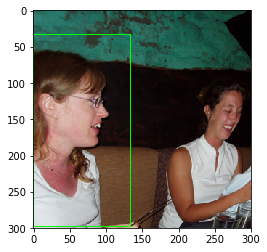

In [270]:
plt.imshow(cv2.rectangle(img, (box[1], box[0]), (box[3], box[2]), (0,255,0), 1).get())

In [148]:
img2 = cv2.imread('voc/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg')

In [150]:
img2.shape

(366, 500, 3)

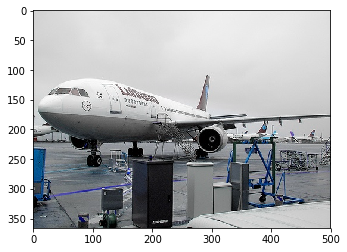

In [152]:
plt.imshow(img2)

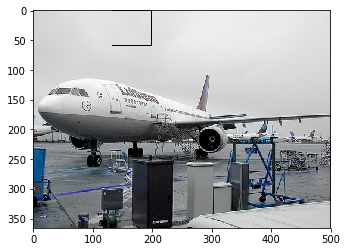

In [154]:
plt.imshow(cv2.rectangle(img2, (box[0], box[1]), (box[2], box[3]), (0,1,0), 1))